In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import torch
from scipy.stats import spearmanr,pearsonr



In [2]:
file = open('cbp_outputs.pckl', 'rb')
cbp_outputs = pickle.load(file)
file.close()

file = open('targets.pckl', 'rb')
target_list = pickle.load(file)
file.close()

file = open('pytorch_outputs.pckl', 'rb')
pytorch_outputs = pickle.load(file)
file.close()

In [3]:
profile_pytorch = [inner_list[1] for inner_list in pytorch_outputs]
profile_cbp = [inner_list[0] for inner_list in cbp_outputs]
profile_target = [inner_list[1] for inner_list in target_list]

In [4]:
total_count_cbp = [inner_list[1] for inner_list in cbp_outputs]


In [5]:
total_count_cbp = np.concatenate(total_count_cbp)

In [6]:
total_count_cbp = np.expm1(total_count_cbp)

In [7]:
profile_cbp = np.concatenate(profile_cbp,axis=0)

In [8]:
profile_pytorch = torch.cat(profile_pytorch,axis=0).cpu().numpy()

In [9]:
profile_target = torch.cat(profile_target,axis=0).cpu().numpy()

In [10]:
total_count_cbp.sum(axis=1).flatten()

array([1357.771  , 1133.7134 , 1434.9149 , ..., 3910.1077 , 2639.0469 ,
        469.86078], dtype=float32)

In [11]:
profile_target.sum(axis=1).flatten()

array([295756., 101706., 125103., ...,  40749., 510199.,  67280.],
      dtype=float32)

In [12]:
import pandas as pd
total_count_df = pd.DataFrame([pd.Series(profile_pytorch.sum(axis=1).flatten()),
             pd.Series(total_count_cbp.sum(axis=1).flatten()),
             pd.Series(profile_target.sum(axis=1).flatten())]
             )
total_count_df = total_count_df.T

In [13]:
total_count_df.columns = ["pytorch","cbp","targets"]

In [14]:
total_count_df["pytorch_logged"] = np.log1p(total_count_df["pytorch"])
total_count_df["cbp_logged"] = np.log1p(total_count_df["cbp"])
total_count_df["targets_logged"] = np.log1p(total_count_df["targets"])

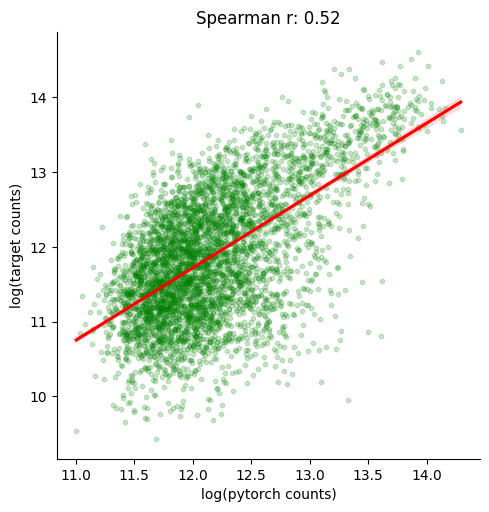

In [38]:
spearman_corr, _ = spearmanr(total_count_df['pytorch_logged'], total_count_df['targets_logged'])
spearman_r2 = spearman_corr 

# Create the scatter plot with regression line
sns.lmplot(data=total_count_df, x='pytorch_logged', y='targets_logged', scatter_kws={'s': 10, 'color': 'green', 'alpha' : 0.2}, line_kws={'color': 'red'})

# Annotate the plot with the Spearman R² value
plt.title(f'Spearman r: {spearman_r2:.2f}')
plt.xlabel('log(pytorch counts)')
plt.ylabel('log(target counts)')

# Display the plot
plt.show()

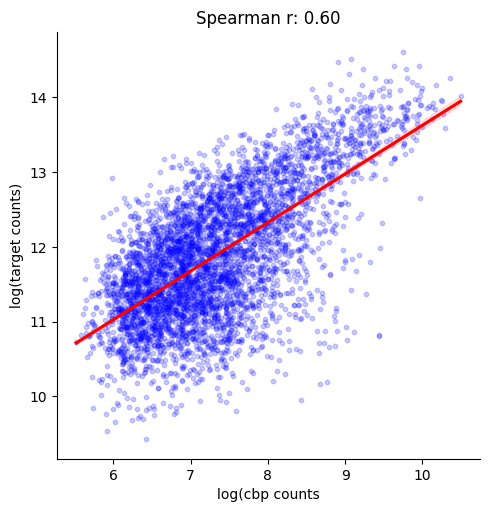

In [39]:
spearman_corr, _ = spearmanr(total_count_df['cbp_logged'], total_count_df['targets_logged'])
spearman_r2 = spearman_corr

# Create the scatter plot with regression line
sns.lmplot(data=total_count_df, x='cbp_logged', y='targets_logged', scatter_kws={'s': 10, 'color': 'blue', 'alpha' : 0.2}, line_kws={'color': 'red'})

# Annotate the plot with the Spearman R² value
plt.title(f'Spearman r: {spearman_r2:.2f}')
plt.xlabel('log(cbp counts')
plt.ylabel('log(target counts)')

# Display the plot
plt.show()

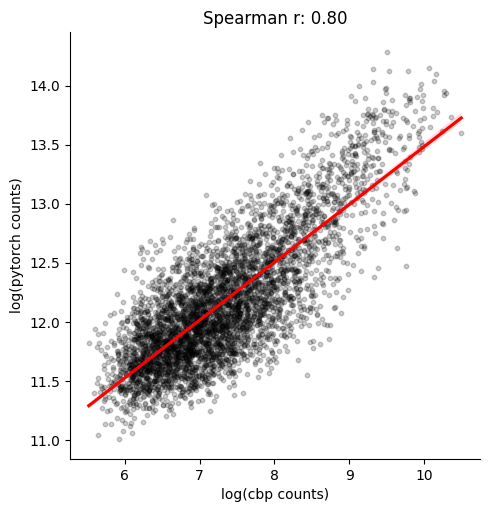

In [40]:
spearman_corr, _ = pearsonr(total_count_df['cbp_logged'], total_count_df['pytorch_logged'])
spearman_r2 = spearman_corr 

# Create the scatter plot with regression line
sns.lmplot(data=total_count_df, x='cbp_logged', y='pytorch_logged', scatter_kws={'s': 10, 'color': 'black', 'alpha' : 0.2}, line_kws={'color': 'red'})

# Annotate the plot with the Spearman R² value
plt.title(f'Spearman r: {spearman_r2:.2f}')
plt.xlabel('log(cbp counts)')
plt.ylabel('log(pytorch counts)')

# Display the plot
plt.show()

### Although I'm not explicitly testing counts, just taking from the profile prediciton (implicility from MSE)

In [26]:
profile_pytorch = [inner_list[1] for inner_list in pytorch_outputs]
profile_cbp = [inner_list[0] for inner_list in cbp_outputs]
profile_target = [inner_list[1] for inner_list in target_list]

In [27]:
multipled_profile = []

# Iterate through each profile in profile_cbp and multiply by the corresponding total_count_cbp
for cbp, count in zip(profile_cbp, total_count_cbp):
    # Multiply element-wise (broadcasting)
    multipled_profile.append(cbp * count)

In [28]:
import scipy
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

cbp_correlations = []
pytorch_correlations = []
cbp_js_divergences = []
pytorch_js_divergences = []
cbp_kl_divergences = []
pytorch_kl_divergences = []
cbp_cosine_similarities = []
pytorch_cosine_similarities = []

for cbp, target, pytorch in zip(multipled_profile, profile_target, profile_pytorch):
    # Initialize lists to store metrics for each element
    element_cbp_correlations = []
    element_pytorch_correlations = []
    element_cbp_js_divergences = []
    element_pytorch_js_divergences = []
    element_cbp_kl_divergences = []
    element_pytorch_kl_divergences = []
    element_cbp_cosine_similarities = []
    element_pytorch_cosine_similarities = []
    
    # Iterate over corresponding elements in the profiles
    for cbp_element, target_element, pytorch_element in zip(cbp, target, pytorch):
        # Convert tensors to NumPy arrays
        cbp_array = cbp_element
        target_array = target_element.cpu().numpy()
        pytorch_array = pytorch_element.cpu().numpy()
        
        # Normalize arrays to make them valid probability distributions
        cbp_norm = cbp_array / np.sum(cbp_array + 1e-12)
        target_norm = target_array / np.sum(target_array + 1e-12)
        pytorch_norm = pytorch_array / np.sum(pytorch_array + 1e-12)
        
        # Compute Spearman correlation
        corr_cbp, _ = scipy.stats.spearmanr(target_array, cbp_array)
        element_cbp_correlations.append(corr_cbp)
        
        corr_pytorch, _ = scipy.stats.spearmanr(target_array, pytorch_array)
        element_pytorch_correlations.append(corr_pytorch)
        
        # Compute Jensen-Shannon Divergence
        js_cbp = jensenshannon(target_norm, cbp_norm)
        element_cbp_js_divergences.append(js_cbp)
        
        js_pytorch = jensenshannon(target_norm, pytorch_norm)
        element_pytorch_js_divergences.append(js_pytorch)
        
        # Compute KL Divergence
        kl_cbp = entropy(target_norm, cbp_norm)
        element_cbp_kl_divergences.append(kl_cbp)
        
        kl_pytorch = entropy(target_norm, pytorch_norm)
        element_pytorch_kl_divergences.append(kl_pytorch)
        
        # Compute Cosine Similarity
        cosine_cbp = 1 - scipy.spatial.distance.cosine(target_array, cbp_array)
        element_cbp_cosine_similarities.append(cosine_cbp)
        
        cosine_pytorch = 1 - scipy.spatial.distance.cosine(target_array, pytorch_array)
        element_pytorch_cosine_similarities.append(cosine_pytorch)
    
    # Flatten and compute means for each metric
    cbp_correlations.append(np.mean(element_cbp_correlations))
    pytorch_correlations.append(np.mean(element_pytorch_correlations))
    cbp_js_divergences.append(np.mean(element_cbp_js_divergences))
    pytorch_js_divergences.append(np.mean(element_pytorch_js_divergences))
    cbp_kl_divergences.append(np.mean(element_cbp_kl_divergences))
    pytorch_kl_divergences.append(np.mean(element_pytorch_kl_divergences))
    cbp_cosine_similarities.append(np.mean(element_cbp_cosine_similarities))
    pytorch_cosine_similarities.append(np.mean(element_pytorch_cosine_similarities))


<Figure size 1200x800 with 0 Axes>

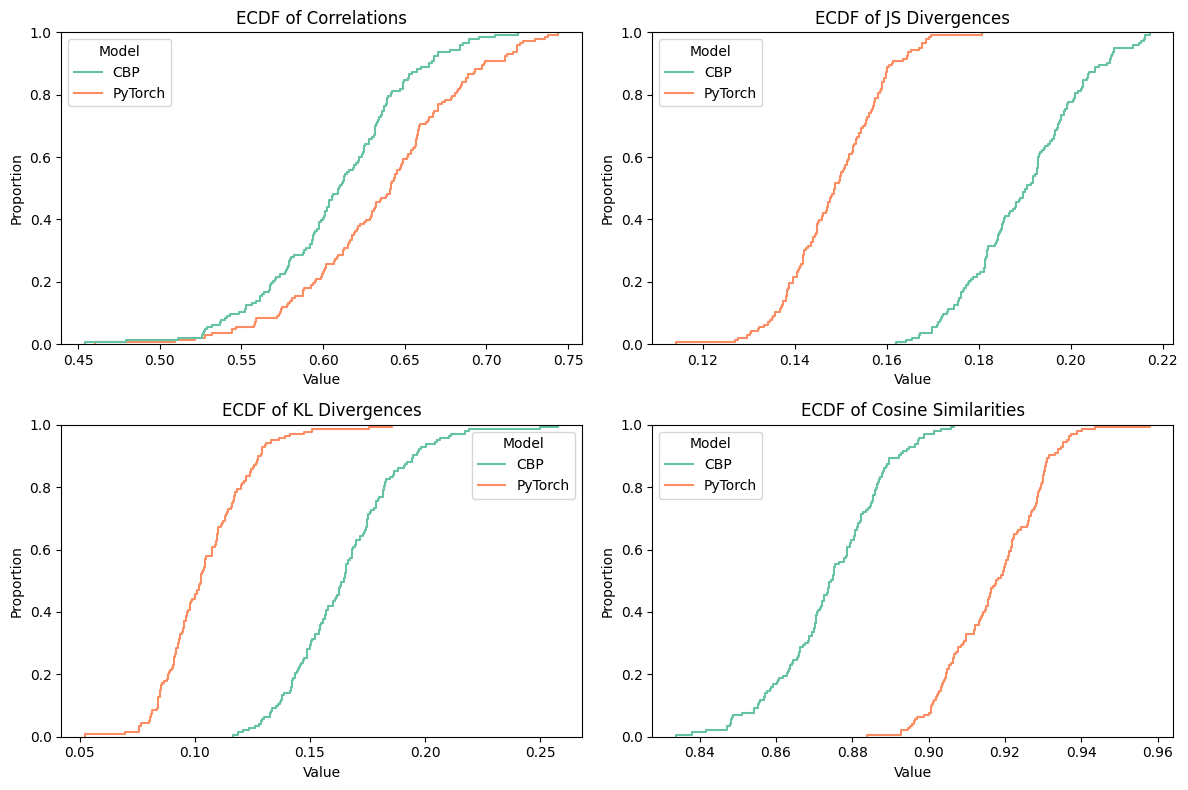

In [29]:
data = {
    'Value': cbp_correlations + pytorch_correlations + cbp_js_divergences + pytorch_js_divergences + cbp_kl_divergences + pytorch_kl_divergences + cbp_cosine_similarities + pytorch_cosine_similarities,
    'Metric': ['Correlation']*len(cbp_correlations)*2 + ['JS Divergence']*len(cbp_js_divergences)*2 + ['KL Divergence']*len(cbp_kl_divergences)*2 + ['Cosine Similarity']*len(cbp_cosine_similarities)*2,
    'Model': ['CBP']*len(cbp_correlations) + ['PyTorch']*len(pytorch_correlations) + ['CBP']*len(cbp_js_divergences) + ['PyTorch']*len(pytorch_js_divergences) + ['CBP']*len(cbp_kl_divergences) + ['PyTorch']*len(pytorch_kl_divergences) + ['CBP']*len(cbp_cosine_similarities) + ['PyTorch']*len(pytorch_cosine_similarities)
}

df = pd.DataFrame(data)

# Plot ECDFs
plt.figure(figsize=(12, 8))
custom_palette = sns.color_palette("Set2", 2)  # Using Set2 palette with 2 colors

# Plot ECDFs
plt.figure(figsize=(12, 8))

# Correlation
plt.subplot(2, 2, 1)
sns.ecdfplot(data=df[df['Metric'] == 'Correlation'], x='Value', hue='Model', palette=custom_palette)
plt.title('ECDF of Correlations')

# JS Divergence
plt.subplot(2, 2, 2)
sns.ecdfplot(data=df[df['Metric'] == 'JS Divergence'], x='Value', hue='Model', palette=custom_palette)
plt.title('ECDF of JS Divergences')

# KL Divergence
plt.subplot(2, 2, 3)
sns.ecdfplot(data=df[df['Metric'] == 'KL Divergence'], x='Value', hue='Model', palette=custom_palette)
plt.title('ECDF of KL Divergences')

# Cosine Similarity
plt.subplot(2, 2, 4)
sns.ecdfplot(data=df[df['Metric'] == 'Cosine Similarity'], x='Value', hue='Model', palette=custom_palette)
plt.title('ECDF of Cosine Similarities')

plt.tight_layout()
plt.show()

In [30]:
batch_metrics = pd.DataFrame([cbp_correlations,pytorch_correlations,cbp_js_divergences,pytorch_js_divergences,
              cbp_cosine_similarities, pytorch_cosine_similarities,cbp_kl_divergences,pytorch_kl_divergences]).T
batch_metrics.columns = ["cbp_spearman","pytorch_spearman",
                         "cbp_js","pytorch_js",
                         "cbp_cosine","pytorch_cosine",
                         "cbp_kl","pytorch_kl"]


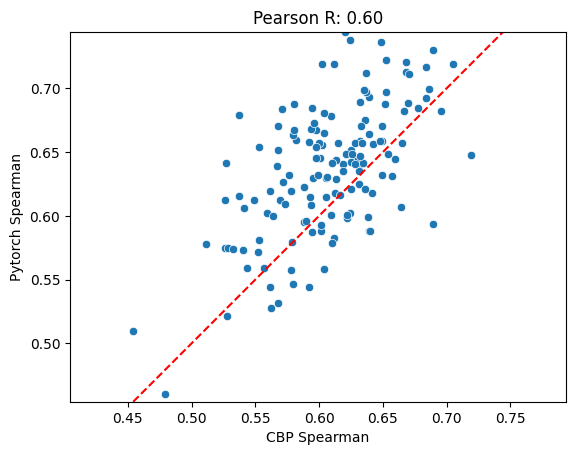

In [31]:
pearson_corr, _ = pearsonr(batch_metrics['cbp_spearman'], batch_metrics['pytorch_spearman'])
spearman_r2 = pearson_corr 

# Create the scatter plot with regression line
sns.scatterplot(
    data=batch_metrics,
    x='cbp_spearman',
    y='pytorch_spearman',
    #scatter_kws={'s': 10, 'color': 'black', 'alpha': 0.2},
    #line_kws={'color': 'red'}
)

# Ensure the axes have the same scale
plt.axis('equal')

# Get the min and max values for both axes
min_val = min(batch_metrics['cbp_spearman'].min(), batch_metrics['pytorch_spearman'].min())
max_val = max(batch_metrics['cbp_spearman'].max(), batch_metrics['pytorch_spearman'].max())

# Set identical axis limits
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Plot the x = y line
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x = y')

# Annotate the plot with the Spearman R² value
plt.title(f'Pearson R: {spearman_r2:.2f}')
plt.xlabel('CBP Spearman')
plt.ylabel('Pytorch Spearman')

# Display the plot
plt.show()

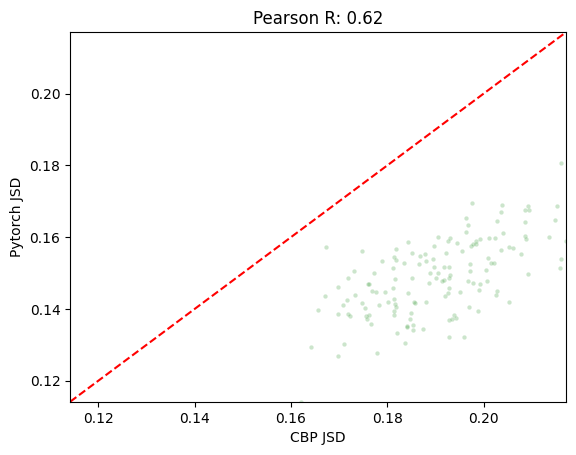

In [32]:
pearson_corr, _ = pearsonr(batch_metrics['cbp_js'], batch_metrics['pytorch_js'])
pearson_r2 = pearson_corr 

# Create the scatter plot
sns.scatterplot(
    data=batch_metrics,
    x='cbp_js',
    y='pytorch_js',
    s=10,
    color='green',
    alpha=0.2
)

# Get the min and max values for both axes
min_val = min(batch_metrics['cbp_js'].min(), batch_metrics['pytorch_js'].min())
max_val = max(batch_metrics['cbp_js'].max(), batch_metrics['pytorch_js'].max())

# Set identical axis limits
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Plot the x = y line
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x = y')

# Annotate the plot with the Pearson R² value
plt.title(f'Pearson R: {pearson_r2:.2f}')
plt.xlabel('CBP JSD')
plt.ylabel('Pytorch JSD')

# Add a legend
#plt.legend()

# Display the plot
plt.show()

In [38]:
batch_metrics

cbp_spearman  pytorch_spearman    cbp_js  pytorch_js  cbp_cosine  \
0        0.714285          0.755722  0.208381    0.152414    0.860987   
1        0.576046          0.572653  0.182605    0.161948    0.875821   
2        0.645736          0.670350  0.203710    0.150084    0.861997   
3        0.535548          0.661543  0.178262    0.128699    0.891138   
4        0.598689          0.660594  0.202730    0.149691    0.865375   
..            ...               ...       ...         ...         ...   
449      0.595288          0.594109  0.179053    0.150295    0.882892   
450      0.583405          0.588024  0.180951    0.152697    0.883454   
451      0.700104          0.667578  0.204629    0.157379    0.860933   
452      0.677497          0.710019  0.185545    0.125548    0.885568   
453      0.572164          0.578219  0.201155    0.171948    0.864447   

     pytorch_cosine    cbp_kl  pytorch_kl  
0          0.921655  0.191826    0.106204  
1          0.894179  0.155313    0.130553  
2          0.926070  0.180247    0.092791  
3          0.939312  0.138708    0.075170  
4          0.923422  0.185251    0.103279  
..              ...       ...         ...  
449        0.911256  0.142110    0.108139  
450        0.908571  0.153615    0.113859  
451        0.914378  0.189953    0.113319  
452        0.946496  0.150230    0.070311  
453        0.896582  0.180457    0.128442  

[454 rows x 8 columns]

/wynton/home/corces/vishvak/miniforge3/envs/chrombpnet/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


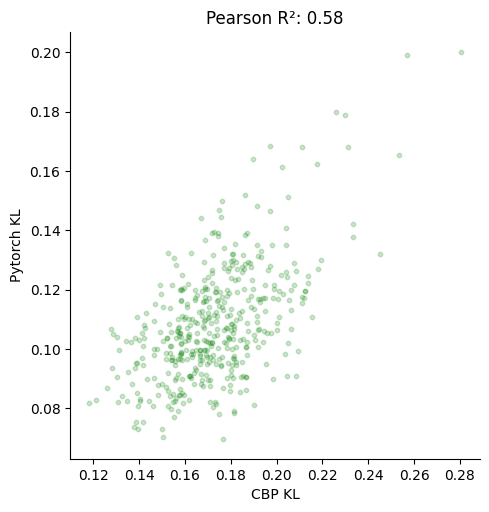

In [40]:
#pearson_corr, _ = pearsonr(batch_metrics['cbp_kl'], batch_metrics['pytorch_kl'])
#spearman_r2 = spearman_corr ** 2

# Create the scatter plot with regression line
sns.lmplot(data=batch_metrics, x='cbp_kl', y='pytorch_kl', scatter_kws={'s': 10, 'color': 'green', 'alpha' : 0.2}, line_kws={'color': 'red'})

# Annotate the plot with the Spearman R² value
plt.title(f'Pearson R²: {spearman_r2:.2f}')
plt.xlabel('CBP KL')
plt.ylabel('Pytorch KL')

# Display the plot
plt.show()

In [ ]:
pearson_corr, _ = pearsonr(batch_metrics['cbp_spearman'], batch_metrics['pytorch_spearman'])
spearman_r2 = spearman_corr ** 2

# Create the scatter plot with regression line
sns.lmplot(data=batch_metrics, x='cbp_spearman', y='pytorch_spearman', scatter_kws={'s': 10, 'color': 'black', 'alpha' : 0.2}, line_kws={'color': 'red'})

# Annotate the plot with the Spearman R² value
plt.title(f'Pearson R²: {spearman_r2:.2f}')
plt.xlabel('cbp spearman')
plt.ylabel('pytorch spearman')

# Display the plot
plt.show()

In [34]:
profile_cbp_concat = np.concatenate(multipled_profile)

In [35]:
profile_pytorch_concat = (torch.cat(profile_pytorch)).cpu().numpy()
profile_targets_concat = (torch.cat(profile_target)).cpu().numpy()

In [49]:
for i in range(10,20):
    print(i)

10
11
12
13
14
15
16
17
18
19


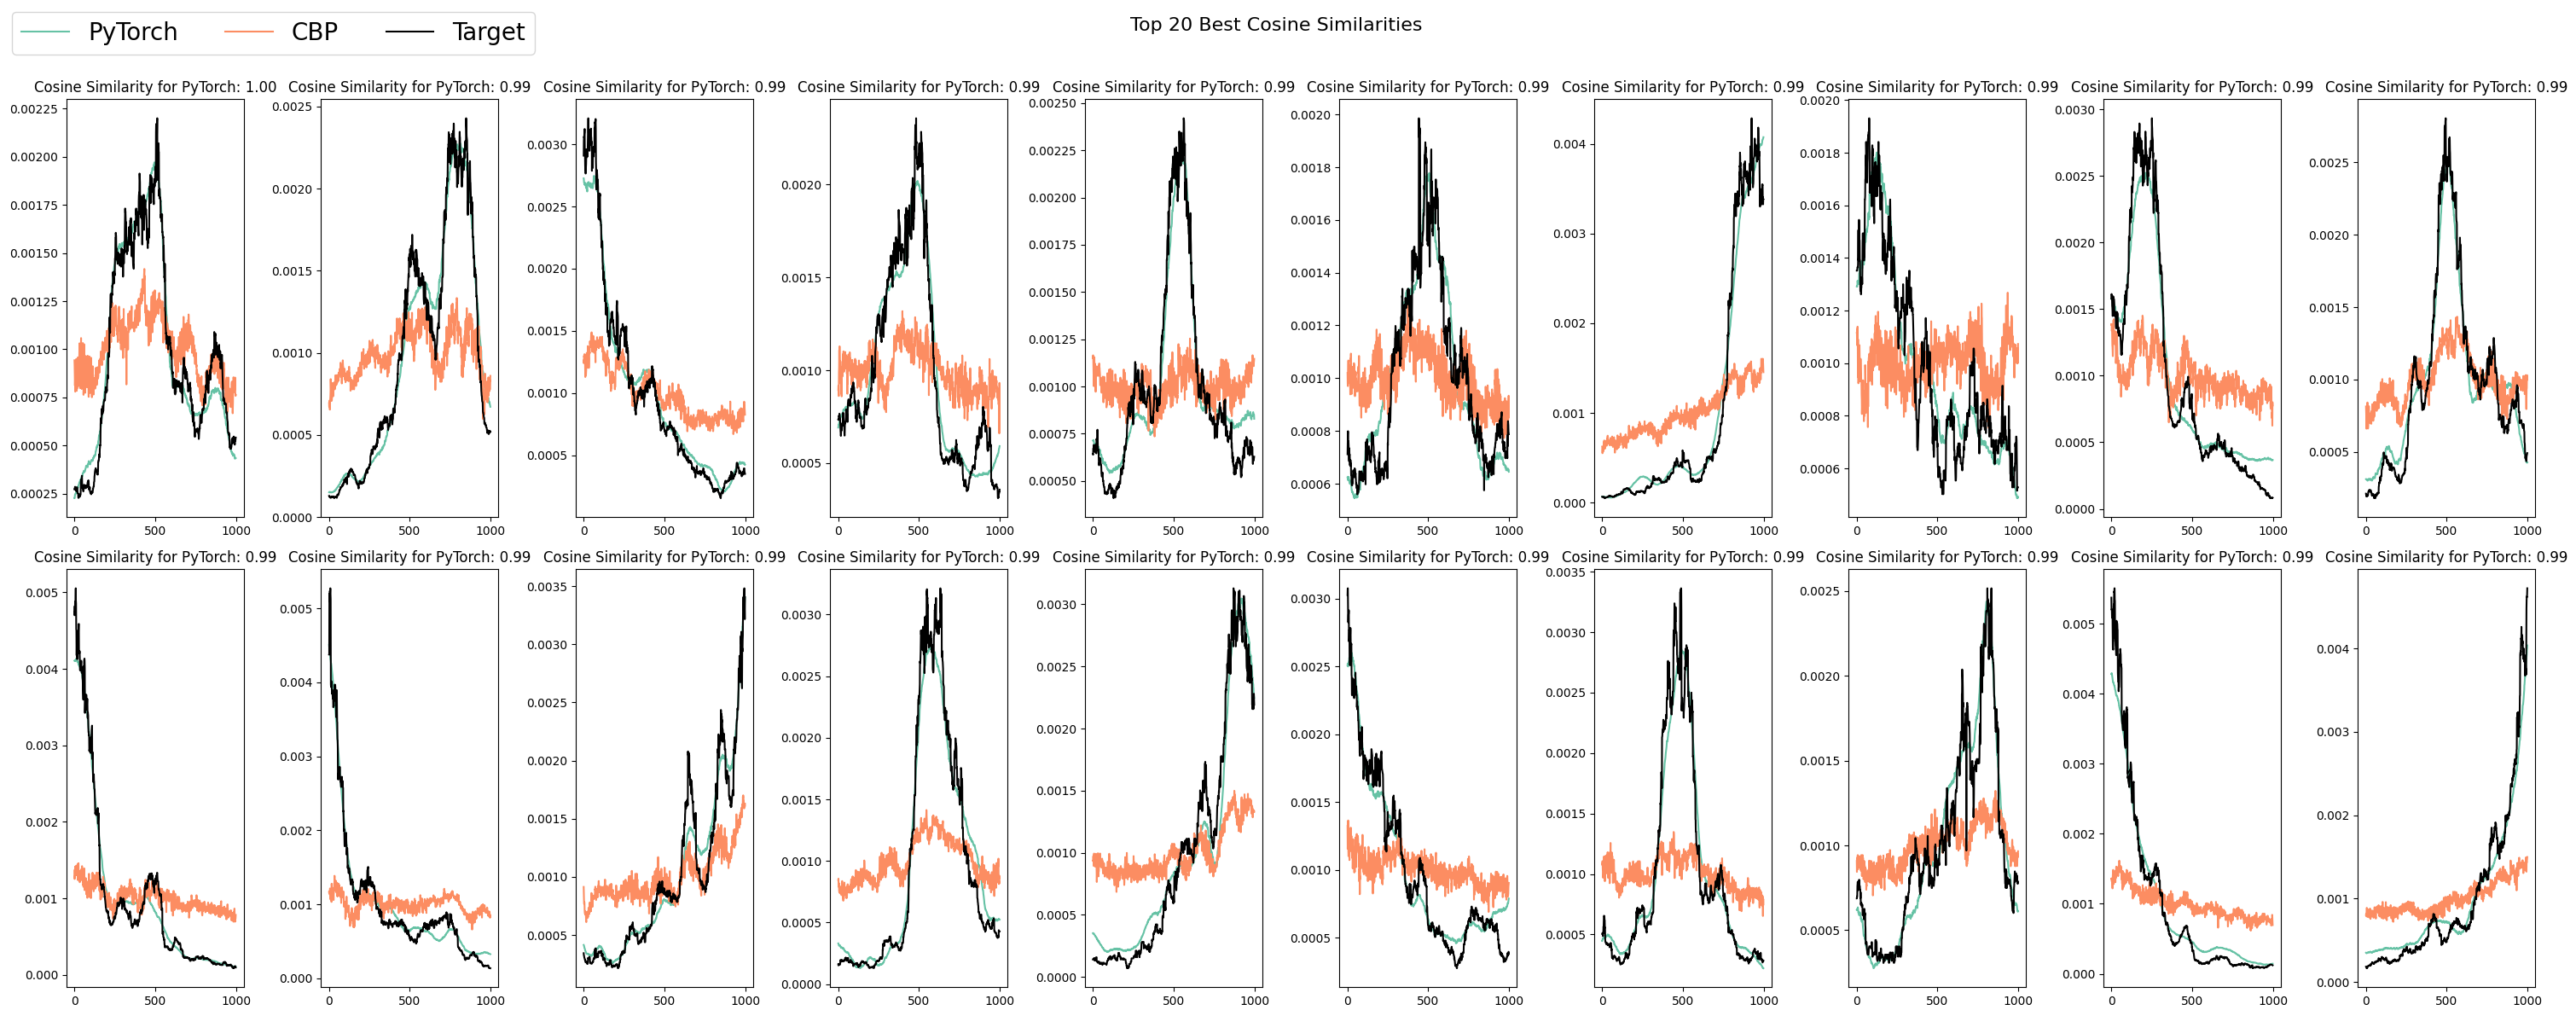

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim_pytorch = [cosine_similarity(pytorch.reshape(1, -1), target.reshape(1, -1))[0][0]
                   for pytorch, target in zip(profile_pytorch_concat, profile_targets_concat)]
cos_sim_cbp = [cosine_similarity(cbp.reshape(1, -1), target.reshape(1, -1))[0][0]
               for cbp, target in zip(profile_cbp_concat, profile_targets_concat)]

cos_sim_pytorch = np.array(cos_sim_pytorch)
cos_sim_cbp = np.array(cos_sim_cbp)

# Determine the top 10 best and worst indices for PyTorch cosine similarities
top_10_best_idx_pytorch = np.argsort(cos_sim_pytorch)[-20:][::-1]
top_10_worst_idx_pytorch = np.argsort(cos_sim_pytorch)[:20]

# Extract the corresponding tensors
best_tensors_pytorch = profile_pytorch_concat[top_10_best_idx_pytorch]
best_tensors_cbp = profile_cbp_concat[top_10_best_idx_pytorch]
best_tensors_target = profile_targets_concat[top_10_best_idx_pytorch]

worst_tensors_pytorch = profile_pytorch_concat[top_10_worst_idx_pytorch]
worst_tensors_cbp = profile_cbp_concat[top_10_worst_idx_pytorch]
worst_tensors_target = profile_targets_concat[top_10_worst_idx_pytorch]

best_cos_sim = cos_sim_pytorch[top_10_best_idx_pytorch]
worst_cos_sim = cos_sim_pytorch[top_10_worst_idx_pytorch]

# Plot the top 5 best and top 5 worst cosine similarities
fig, axs = plt.subplots(2, 10, figsize=(30, 12))

# Define a custom color palette
palette = sns.color_palette("Set2", 2)

# Plot best tensors
for i in range(10):
    axs[0, i].plot(best_tensors_pytorch[i]/best_tensors_pytorch[i].sum(), label='Best Tensor (PyTorch)', color=palette[0])
    axs[0, i].plot(best_tensors_cbp[i]/best_tensors_cbp[i].sum(), label='Best Tensor (CBP)', color=palette[1])
    axs[0, i].plot(best_tensors_target[i]/best_tensors_target[i].sum(), label='Best Tensor (Target)', color='black')
    axs[0, i].set_title(f'Cosine Similarity for PyTorch: {best_cos_sim[i]:.2f}')
    #axs[0, i].legend()


for i in range(10,20):

    axs[1, i-10].plot(best_tensors_pytorch[i]/best_tensors_pytorch[i].sum(), label='Best Tensor (PyTorch)', color=palette[0])
    axs[1, i-10].plot(best_tensors_cbp[i]/best_tensors_cbp[i].sum(), label='Best Tensor (CBP)', color=palette[1])
    axs[1, i-10].plot(best_tensors_target[i]/best_tensors_target[i].sum(), label='Best Tensor (Target)', color='black')
    axs[1, i-10].set_title(f'Cosine Similarity for PyTorch: {best_cos_sim[i]:.2f}')
    #axs[1, i-10].legend()
# Plot worst tensors

handles = [
    plt.Line2D([0], [0], color=palette[0], label='PyTorch'),
    plt.Line2D([0], [0], color=palette[1], label='CBP'),
    plt.Line2D([0], [0], color='black', label='Target'),
]
fig.legend(handles=handles, loc='upper left', ncol=3, fontsize=20, frameon=True)

# Set the overall title
fig.suptitle('Top 20 Best Cosine Similarities', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

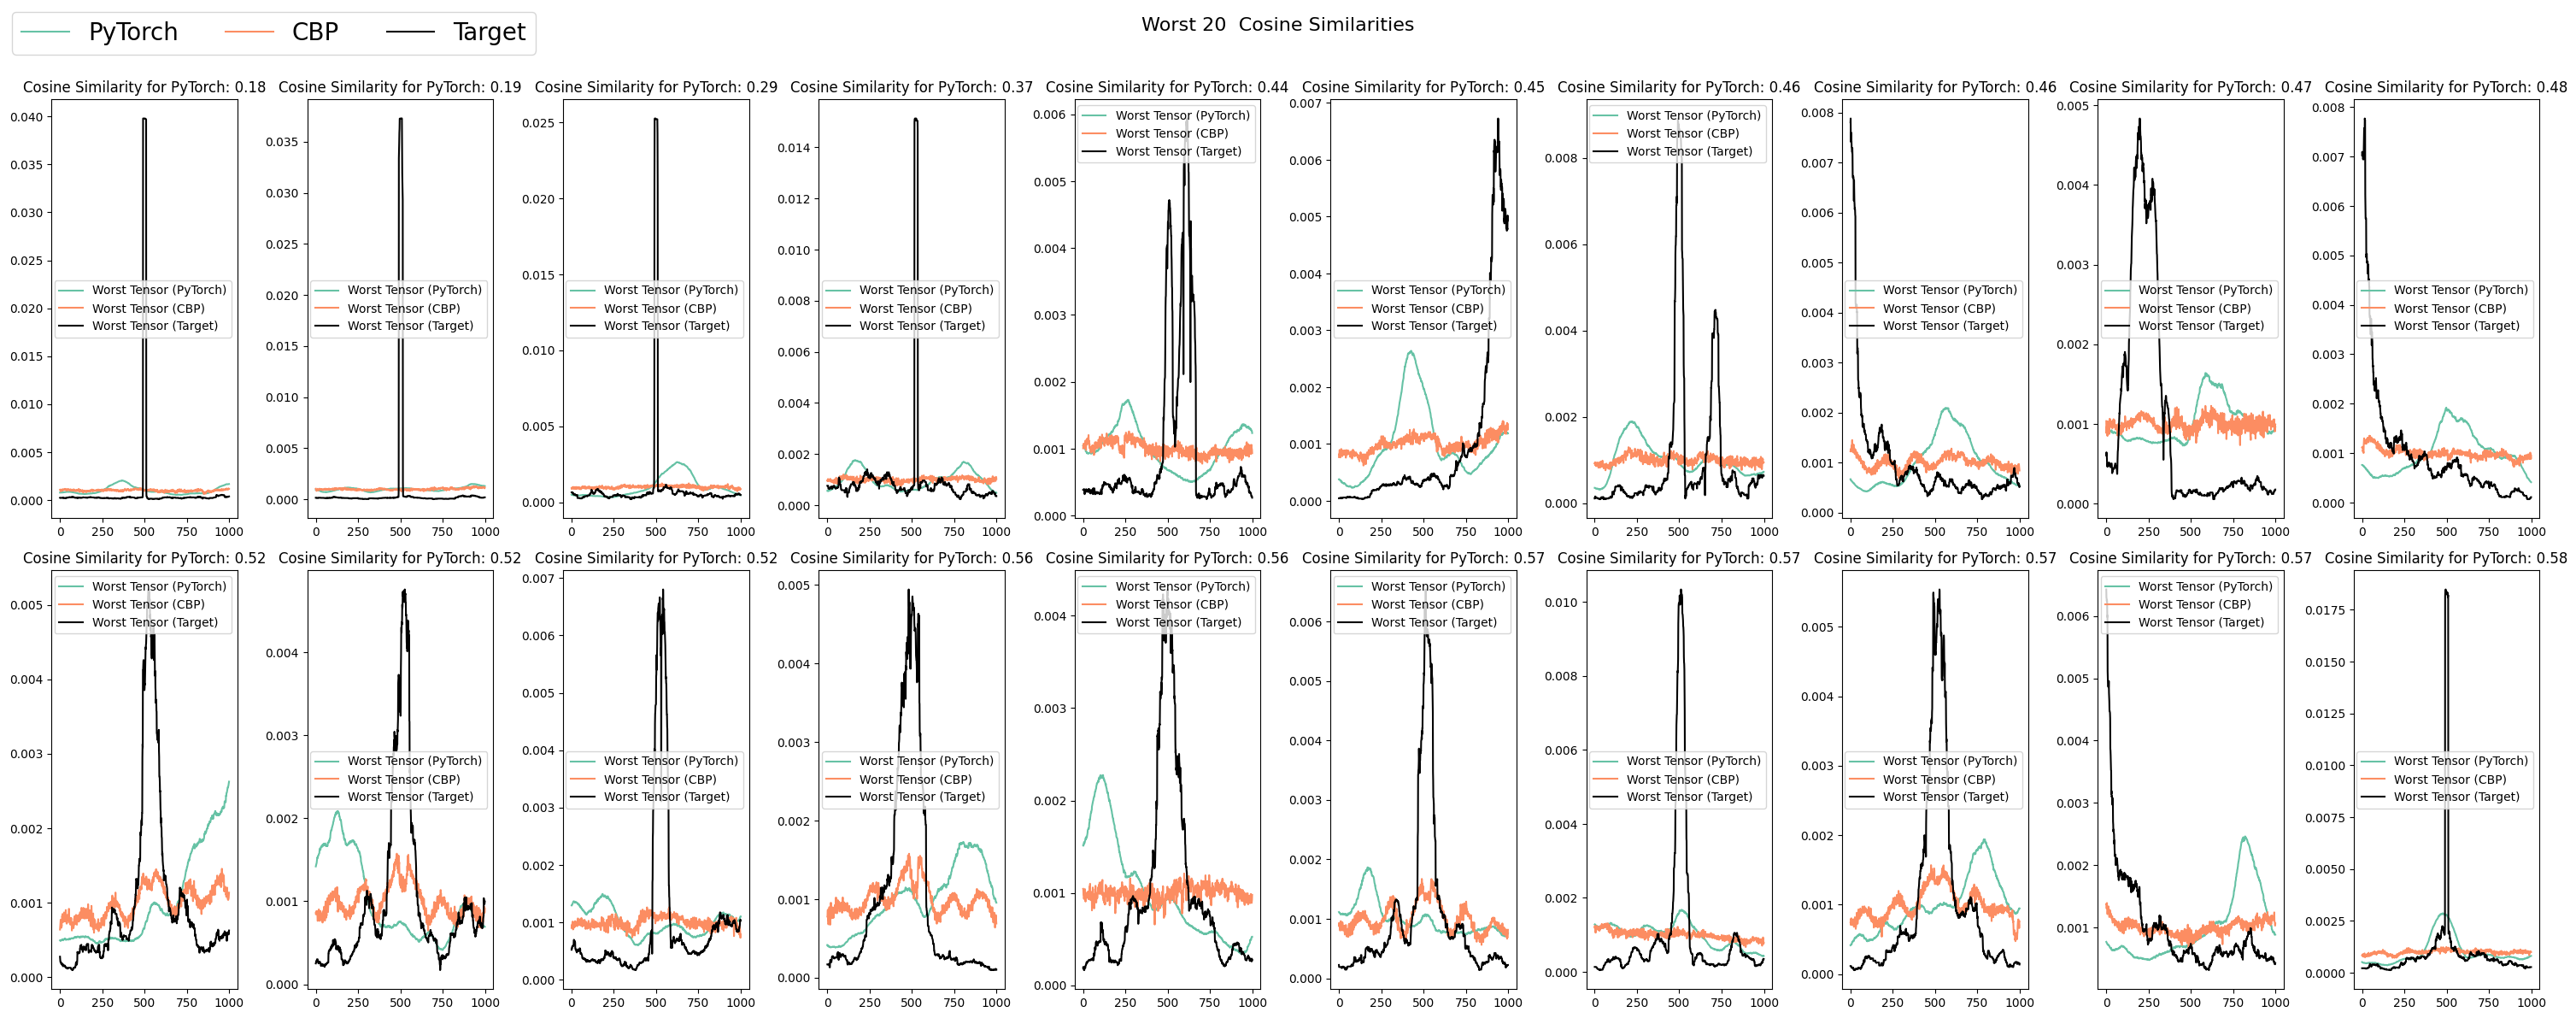

In [41]:
fig, axs = plt.subplots(2, 10, figsize=(30, 12))


for i in range(10):
    axs[0, i].plot(worst_tensors_pytorch[i]/worst_tensors_pytorch[i].sum(), label='Worst Tensor (PyTorch)', color=palette[0])
    axs[0, i].plot(worst_tensors_cbp[i]/worst_tensors_cbp[i].sum(), label='Worst Tensor (CBP)', color=palette[1])
    axs[0, i].plot(worst_tensors_target[i]/worst_tensors_target[i].sum(), label='Worst Tensor (Target)', color='black')
    axs[0, i].set_title(f'Cosine Similarity for PyTorch: {worst_cos_sim[i]:.2f}')
    axs[0, i].legend()


for i in range(10,20):

    axs[1, i-10].plot(worst_tensors_pytorch[i]/worst_tensors_pytorch[i].sum(), label='Worst Tensor (PyTorch)', color=palette[0])
    axs[1, i-10].plot(worst_tensors_cbp[i]/worst_tensors_cbp[i].sum(), label='Worst Tensor (CBP)', color=palette[1])
    axs[1, i-10].plot(worst_tensors_target[i]/worst_tensors_target[i].sum(), label='Worst Tensor (Target)', color='black')
    axs[1, i-10].set_title(f'Cosine Similarity for PyTorch: {worst_cos_sim[i]:.2f}')
    axs[1, i-10].legend()

handles = [
    plt.Line2D([0], [0], color=palette[0], label='PyTorch'),
    plt.Line2D([0], [0], color=palette[1], label='CBP'),
    plt.Line2D([0], [0], color='black', label='Target'),
]
fig.legend(handles=handles, loc='upper left', ncol=3, fontsize=20, frameon=True)
fig.suptitle('Worst 20  Cosine Similarities', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [42]:
from scipy.spatial.distance import jensenshannon
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [43]:
# Ensure profiles are normalized as probability distributions
profile_pytorch_concat_norm = [p / p.sum() for p in profile_pytorch_concat]
profile_cbp_concat_norm = [c / c.sum() for c in profile_cbp_concat]
profile_targets_concat_norm = [t / t.sum() for t in profile_targets_concat]

# Compute JSD for PyTorch and CBP profiles
jsd_pytorch = [jensenshannon(pytorch, target) 
               for pytorch, target in zip(profile_pytorch_concat_norm, profile_targets_concat_norm)]
jsd_cbp = [jensenshannon(cbp, target) 
           for cbp, target in zip(profile_cbp_concat_norm, profile_targets_concat_norm)]

jsd_pytorch = np.array(jsd_pytorch)
jsd_cbp = np.array(jsd_cbp)

# Determine the top 10 best (lowest JSD) and worst indices for PyTorch JSD
top_10_best_idx_pytorch = np.argsort(jsd_pytorch)[:20]  # Lowest JSD is best
top_10_worst_idx_pytorch = np.argsort(jsd_pytorch)[-20:]  # Highest JSD is worst

# Extract the corresponding tensors
best_tensors_pytorch = profile_pytorch_concat[top_10_best_idx_pytorch]
best_tensors_cbp = profile_cbp_concat[top_10_best_idx_pytorch]
best_tensors_target = profile_targets_concat[top_10_best_idx_pytorch]

worst_tensors_pytorch = profile_pytorch_concat[top_10_worst_idx_pytorch]
worst_tensors_cbp = profile_cbp_concat[top_10_worst_idx_pytorch]
worst_tensors_target = profile_targets_concat[top_10_worst_idx_pytorch]

best_jsd = jsd_pytorch[top_10_best_idx_pytorch]
worst_jsd = jsd_pytorch[top_10_worst_idx_pytorch]


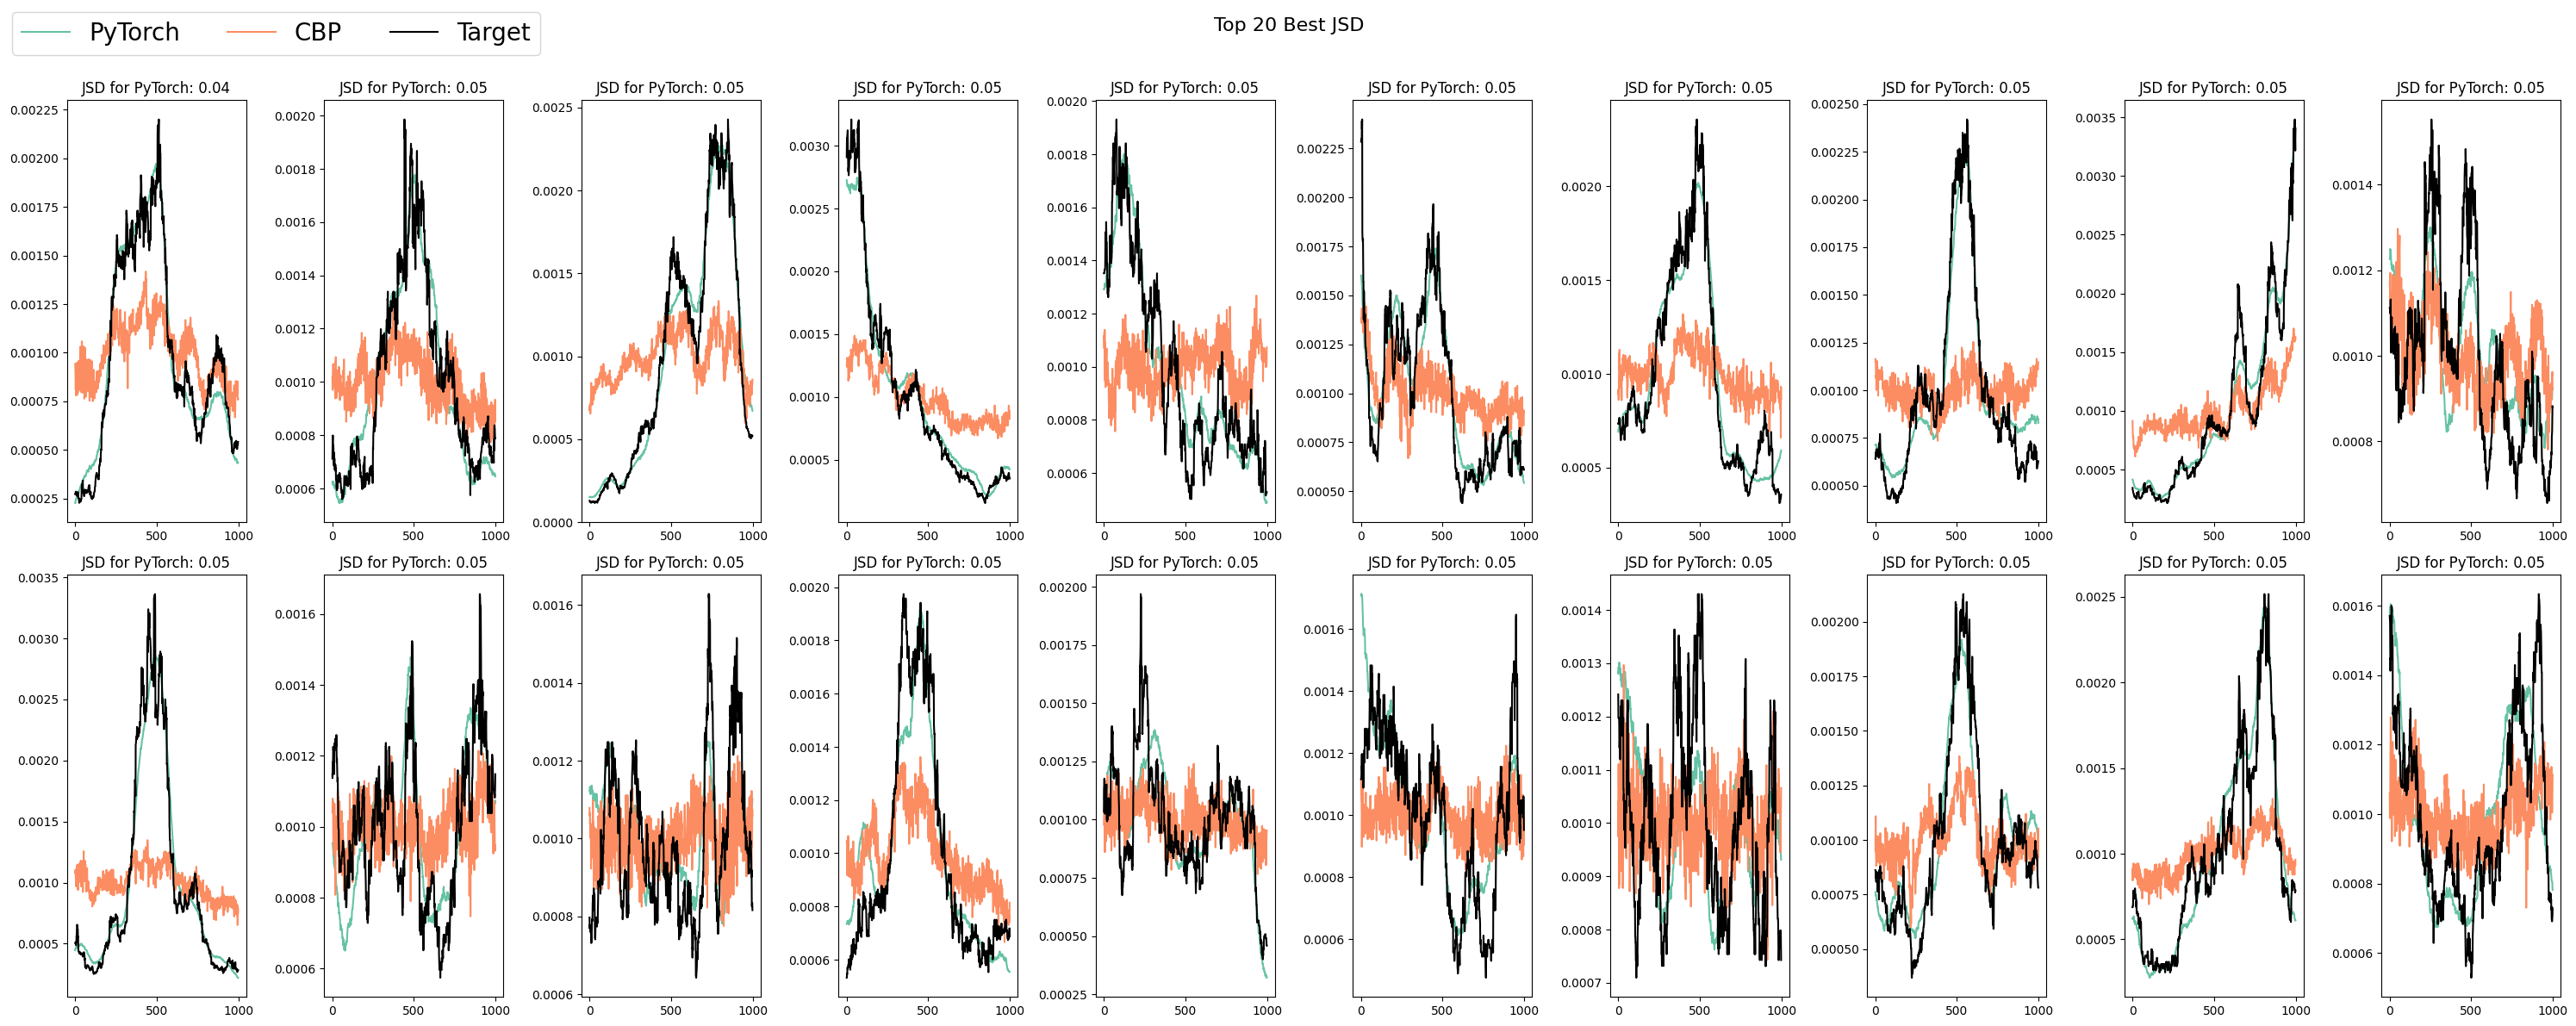

In [46]:


# Plot best tensors
fig, axs = plt.subplots(2, 10, figsize=(30, 12))

# Define a custom color palette
palette = sns.color_palette("Set2", 2)

# Plot best tensors
for i in range(10):
    axs[0, i].plot(best_tensors_pytorch[i]/best_tensors_pytorch[i].sum(), label='Best Tensor (PyTorch)', color=palette[0])
    axs[0, i].plot(best_tensors_cbp[i]/best_tensors_cbp[i].sum(), label='Best Tensor (CBP)', color=palette[1])
    axs[0, i].plot(best_tensors_target[i]/best_tensors_target[i].sum(), label='Best Tensor (Target)', color='black')
    axs[0, i].set_title(f'JSD for PyTorch: {best_jsd[i]:.2f}')
    #axs[0, i].legend()


for i in range(10,20):

    axs[1, i-10].plot(best_tensors_pytorch[i]/best_tensors_pytorch[i].sum(), label='Best Tensor (PyTorch)', color=palette[0])
    axs[1, i-10].plot(best_tensors_cbp[i]/best_tensors_cbp[i].sum(), label='Best Tensor (CBP)', color=palette[1])
    axs[1, i-10].plot(best_tensors_target[i]/best_tensors_target[i].sum(), label='Best Tensor (Target)', color='black')
    axs[1, i-10].set_title(f'JSD for PyTorch: {best_jsd[i]:.2f}')
    #axs[1, i-10].legend()
# Plot worst tensors

handles = [
    plt.Line2D([0], [0], color=palette[0], label='PyTorch'),
    plt.Line2D([0], [0], color=palette[1], label='CBP'),
    plt.Line2D([0], [0], color='black', label='Target'),
]
fig.legend(handles=handles, loc='upper left', ncol=3, fontsize=20, frameon=True)

# Set the overall title
fig.suptitle('Top 20 Best JSD', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


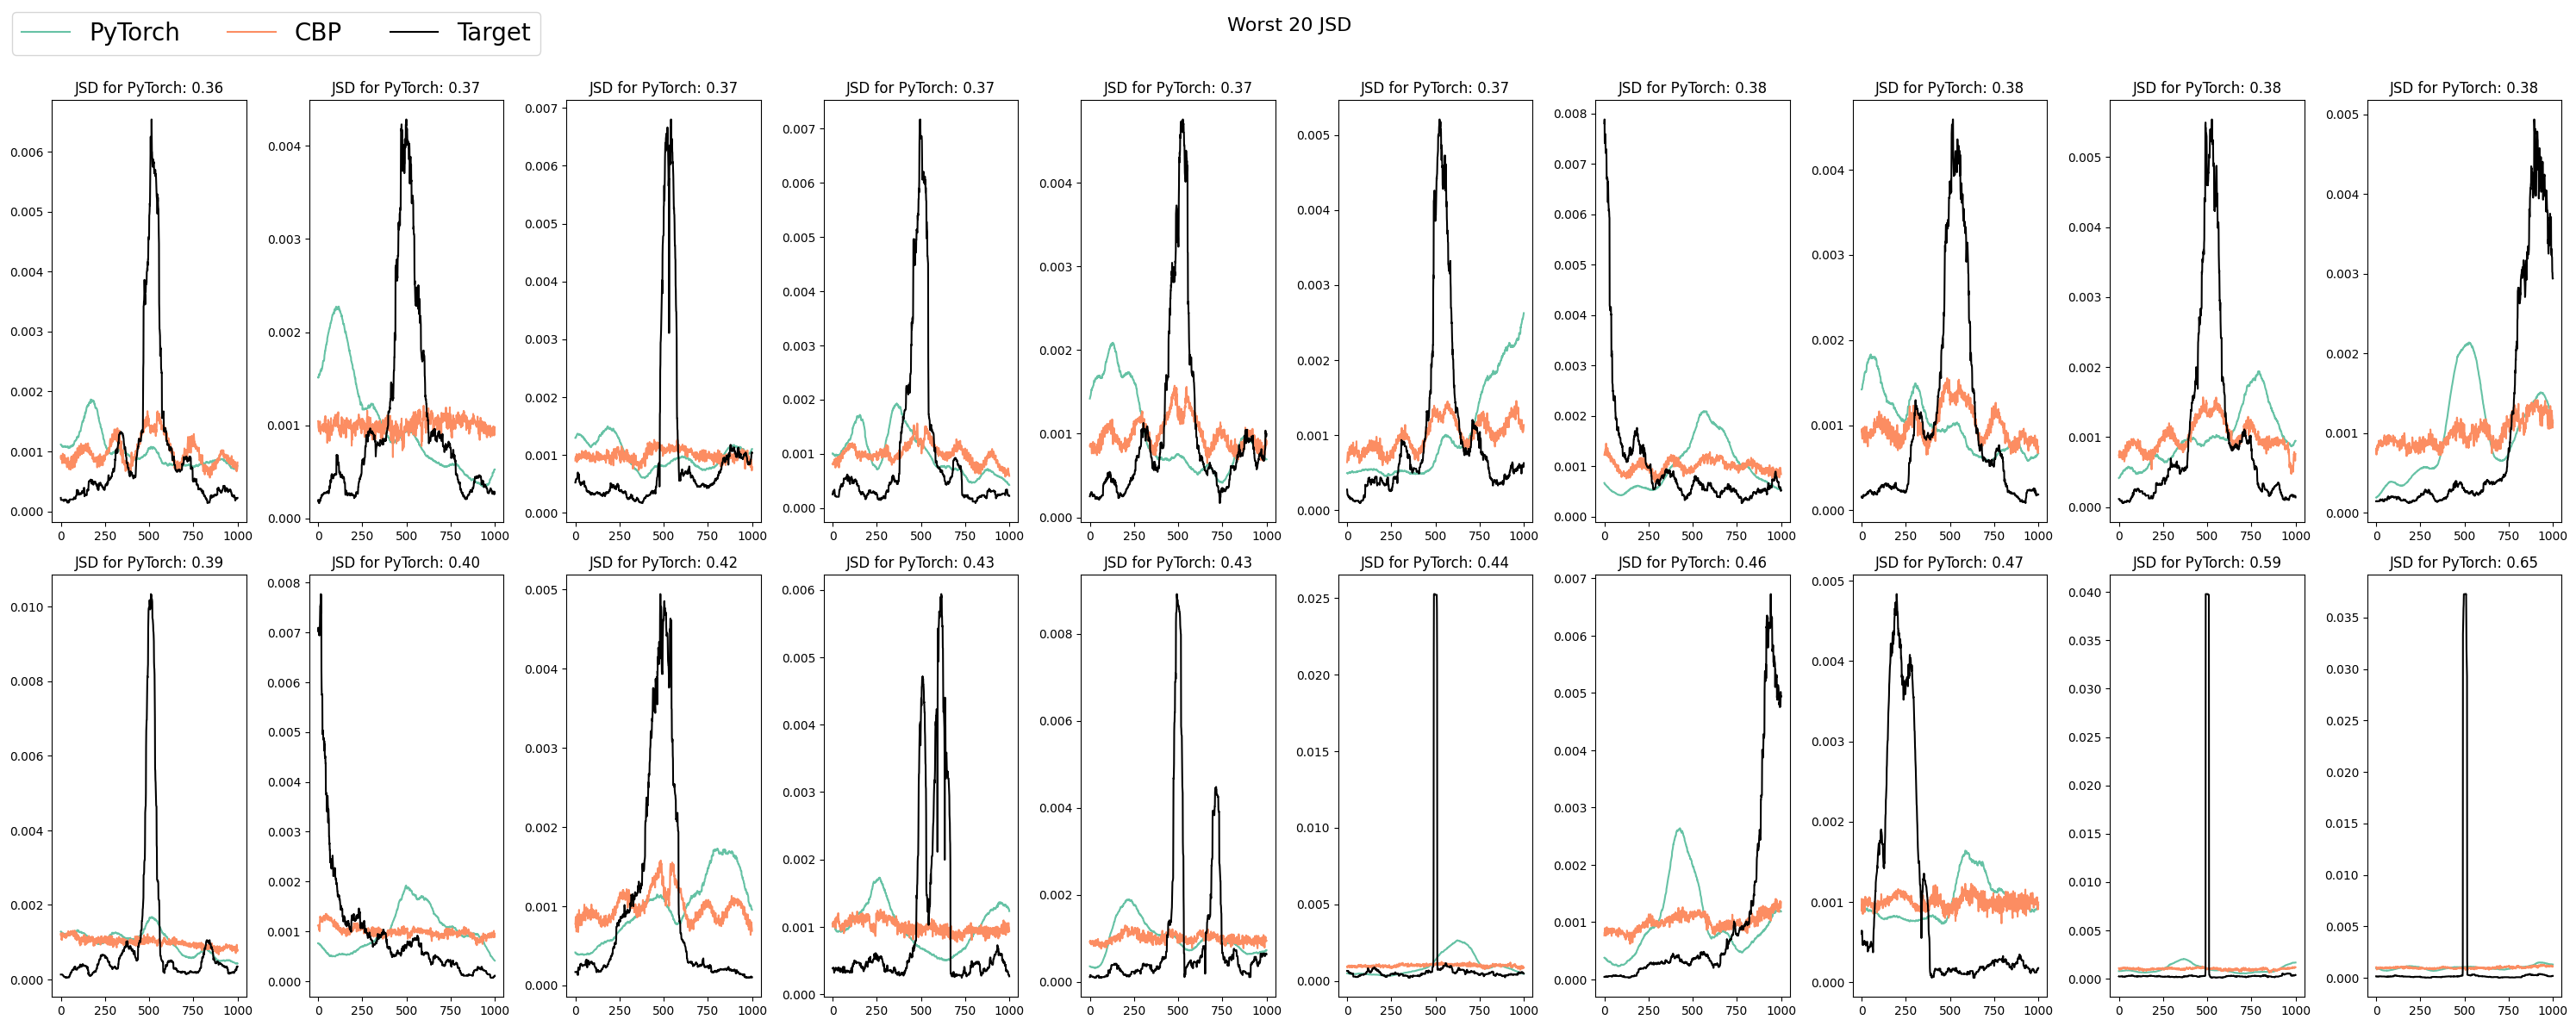

In [45]:
fig, axs = plt.subplots(2, 10, figsize=(30, 12))


for i in range(10):
    axs[0, i].plot(worst_tensors_pytorch[i]/worst_tensors_pytorch[i].sum(), label='Worst Tensor (PyTorch)', color=palette[0])
    axs[0, i].plot(worst_tensors_cbp[i]/worst_tensors_cbp[i].sum(), label='Worst Tensor (CBP)', color=palette[1])
    axs[0, i].plot(worst_tensors_target[i]/worst_tensors_target[i].sum(), label='Worst Tensor (Target)', color='black')
    axs[0, i].set_title(f'JSD for PyTorch: {worst_jsd[i]:.2f}')
    


for i in range(10,20):

    axs[1, i-10].plot(worst_tensors_pytorch[i]/worst_tensors_pytorch[i].sum(), label='Worst Tensor (PyTorch)', color=palette[0])
    axs[1, i-10].plot(worst_tensors_cbp[i]/worst_tensors_cbp[i].sum(), label='Worst Tensor (CBP)', color=palette[1])
    axs[1, i-10].plot(worst_tensors_target[i]/worst_tensors_target[i].sum(), label='Worst Tensor (Target)', color='black')
    axs[1, i-10].set_title(f'JSD for PyTorch: {worst_jsd[i]:.2f}')
    

handles = [
    plt.Line2D([0], [0], color=palette[0], label='PyTorch'),
    plt.Line2D([0], [0], color=palette[1], label='CBP'),
    plt.Line2D([0], [0], color='black', label='Target'),
]
fig.legend(handles=handles, loc='upper left', ncol=3, fontsize=20, frameon=True)
fig.suptitle('Worst 20 JSD', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [47]:
# Ensure profiles are normalized as probability distributions
profile_pytorch_concat_norm = [p / p.sum() for p in profile_pytorch_concat]
profile_cbp_concat_norm = [c / c.sum() for c in profile_cbp_concat]
profile_targets_concat_norm = [t / t.sum() for t in profile_targets_concat]

# Compute JSD for PyTorch and CBP profiles
jsd_pytorch = [jensenshannon(pytorch, target) 
               for pytorch, target in zip(profile_pytorch_concat_norm, profile_targets_concat_norm)]
jsd_cbp = [jensenshannon(cbp, target) 
           for cbp, target in zip(profile_cbp_concat_norm, profile_targets_concat_norm)]

jsd_pytorch = np.array(jsd_pytorch)
jsd_cbp = np.array(jsd_cbp)

# Determine the top 10 best (lowest JSD) and worst indices for PyTorch JSD
top_10_best_idx_pytorch = np.argsort(jsd_cbp)[:20]  # Lowest JSD is best
top_10_worst_idx_pytorch = np.argsort(jsd_cbp)[-20:]  # Highest JSD is worst

# Extract the corresponding tensors
best_tensors_pytorch = profile_pytorch_concat[top_10_best_idx_pytorch]
best_tensors_cbp = profile_cbp_concat[top_10_best_idx_pytorch]
best_tensors_target = profile_targets_concat[top_10_best_idx_pytorch]

worst_tensors_pytorch = profile_pytorch_concat[top_10_worst_idx_pytorch]
worst_tensors_cbp = profile_cbp_concat[top_10_worst_idx_pytorch]
worst_tensors_target = profile_targets_concat[top_10_worst_idx_pytorch]

best_jsd = jsd_pytorch[top_10_best_idx_pytorch]
worst_jsd = jsd_pytorch[top_10_worst_idx_pytorch]


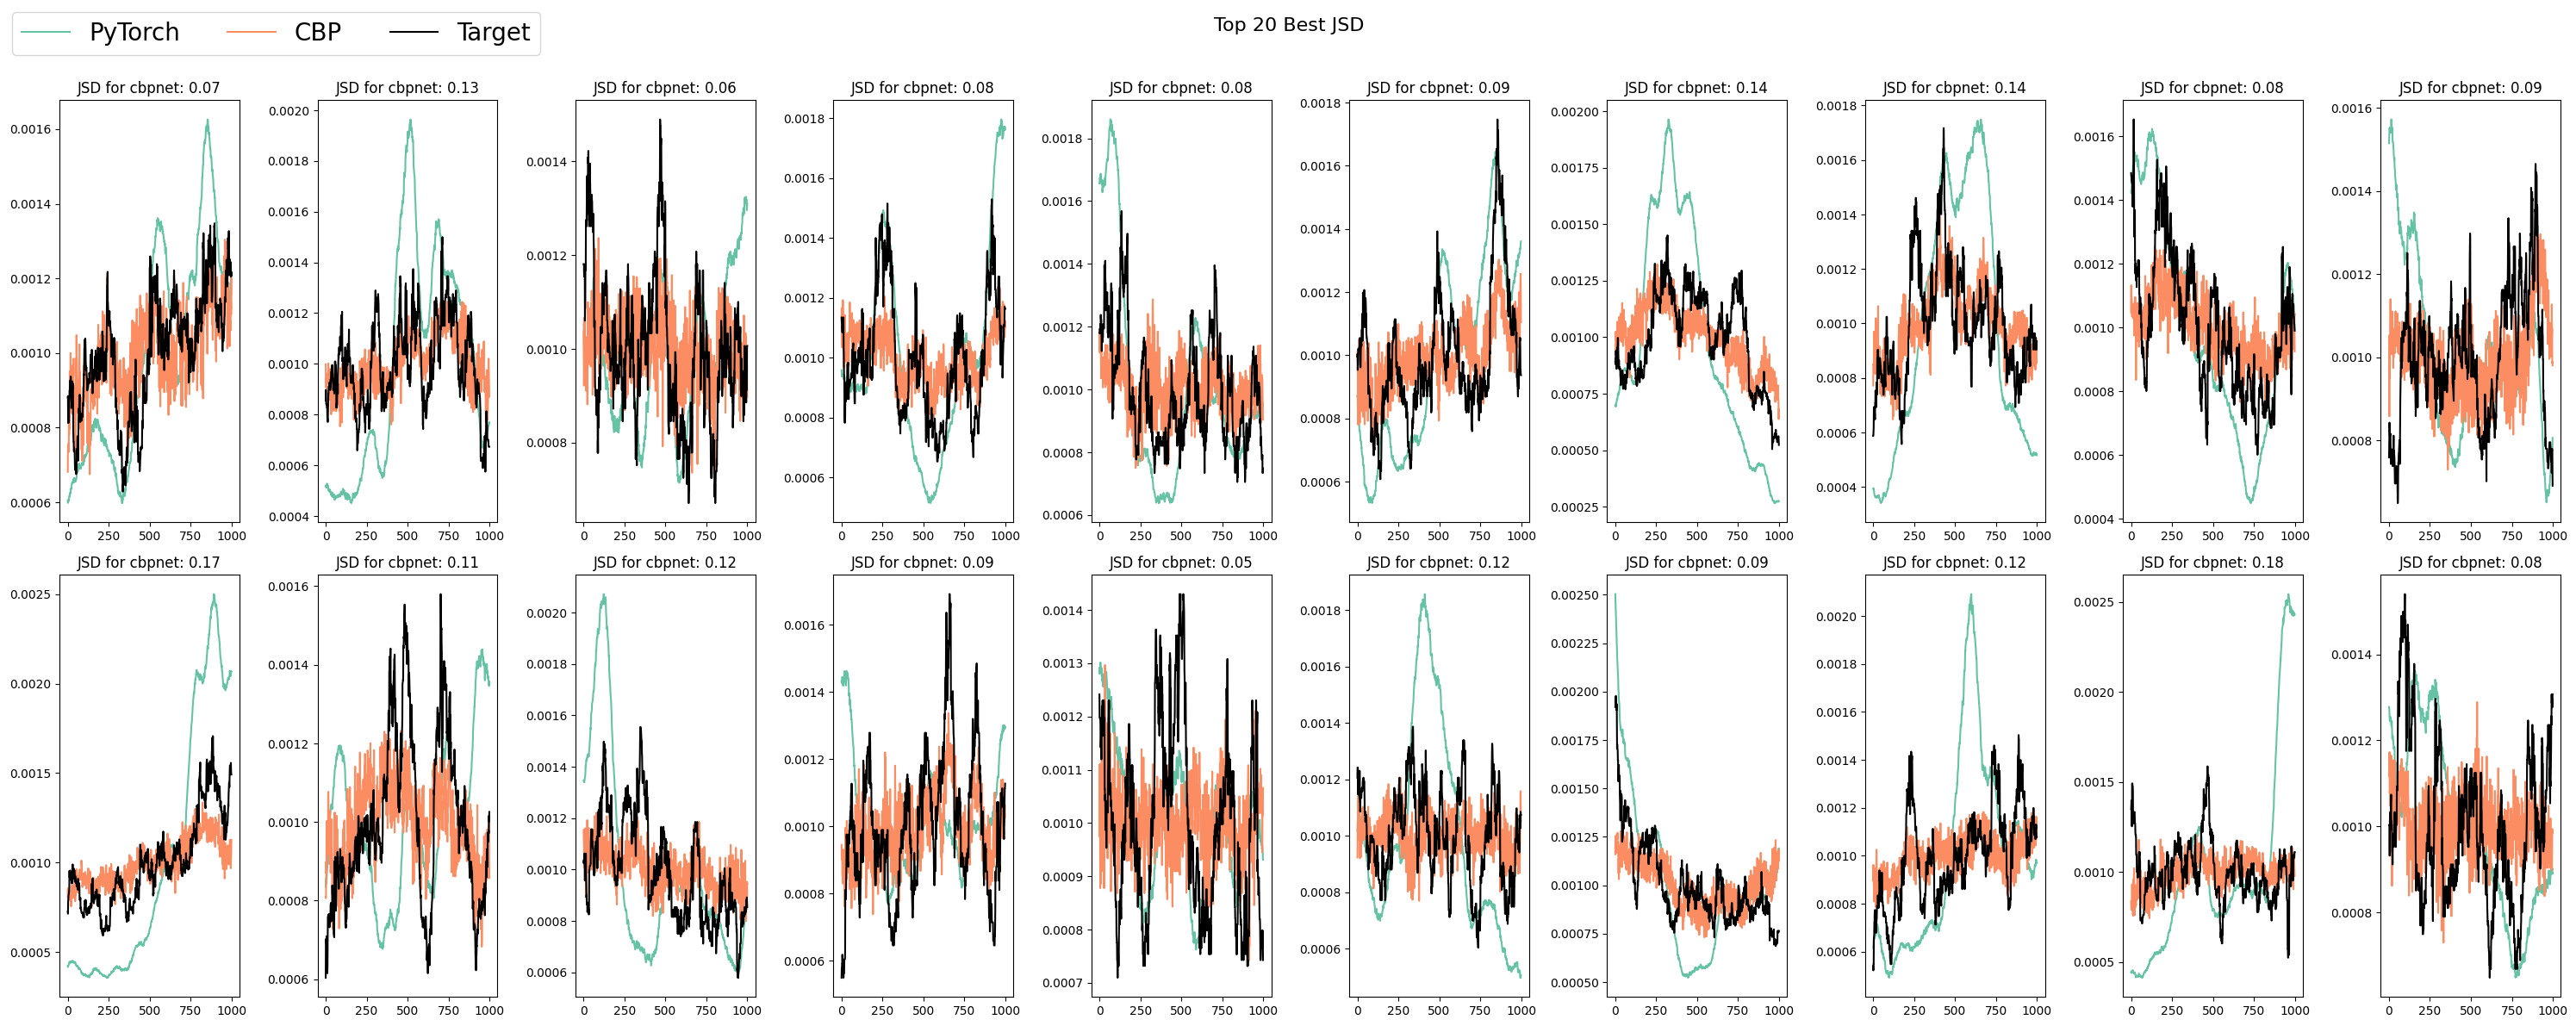

In [49]:


# Plot best tensors
fig, axs = plt.subplots(2, 10, figsize=(30, 12))

# Define a custom color palette
palette = sns.color_palette("Set2", 2)

# Plot best tensors
for i in range(10):
    axs[0, i].plot(best_tensors_pytorch[i]/best_tensors_pytorch[i].sum(), label='Best Tensor (PyTorch)', color=palette[0])
    axs[0, i].plot(best_tensors_cbp[i]/best_tensors_cbp[i].sum(), label='Best Tensor (CBP)', color=palette[1])
    axs[0, i].plot(best_tensors_target[i]/best_tensors_target[i].sum(), label='Best Tensor (Target)', color='black')
    axs[0, i].set_title(f'JSD for cbpnet: {best_jsd[i]:.2f}')
    #axs[0, i].legend()


for i in range(10,20):

    axs[1, i-10].plot(best_tensors_pytorch[i]/best_tensors_pytorch[i].sum(), label='Best Tensor (PyTorch)', color=palette[0])
    axs[1, i-10].plot(best_tensors_cbp[i]/best_tensors_cbp[i].sum(), label='Best Tensor (CBP)', color=palette[1])
    axs[1, i-10].plot(best_tensors_target[i]/best_tensors_target[i].sum(), label='Best Tensor (Target)', color='black')
    axs[1, i-10].set_title(f'JSD for cbpnet: {best_jsd[i]:.2f}')
    #axs[1, i-10].legend()
# Plot worst tensors

handles = [
    plt.Line2D([0], [0], color=palette[0], label='PyTorch'),
    plt.Line2D([0], [0], color=palette[1], label='CBP'),
    plt.Line2D([0], [0], color='black', label='Target'),
]
fig.legend(handles=handles, loc='upper left', ncol=3, fontsize=20, frameon=True)

# Set the overall title
fig.suptitle('Top 20 Best JSD', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [72]:
profile_target_norm = (torch.concat(profile_target)/torch.sum(torch.concat(profile_target),dim=1, keepdim=True)).cpu().numpy()

In [73]:
profile_pytorch_norm = (torch.concat(profile_pytorch)/torch.sum(torch.concat(profile_pytorch),dim=1, keepdim=True)).cpu().numpy()

In [77]:
profile_cbp_norm = np.concatenate(profile_cbp, axis=0)  # Concatenate along the first axis (or another axis if required)
profile_cbp_norm= profile_cbp_norm / np.sum(profile_cbp_norm, axis=1, keepdims=True)  # Use keepdims=True to retain the reduced dimension


In [79]:
jsd_pytorch = [jensenshannon(pytorch, target) 
               for pytorch, target in zip(profile_pytorch_norm, profile_target_norm)]
jsd_cbp = [jensenshannon(cbp, target) 
           for cbp, target in zip(profile_cbp_norm, profile_target_norm)]

In [87]:
jsd_cbp.numpy()

AttributeError: 'list' object has no attribute 'numpy'

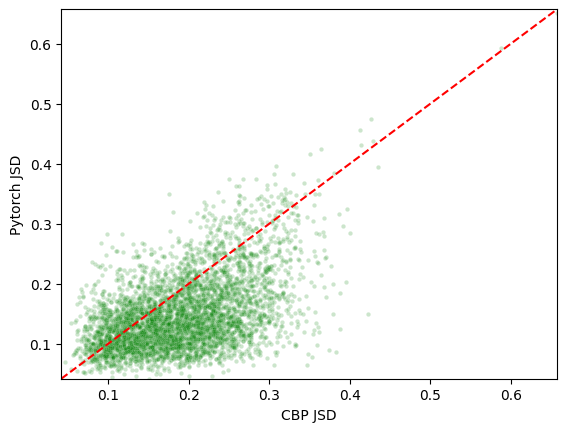

In [89]:
sns.scatterplot(
    #data=batch_metrics,
    x=jsd_cbp,
    y=jsd_pytorch,
    s=10,
    color='green',
    alpha=0.2
)

# Get the min and max values for both axes
min_val = min(min(jsd_cbp), min(jsd_pytorch))
max_val = max(max(jsd_cbp), max(jsd_pytorch))

# Set identical axis limits
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel("CBP JSD")
plt.ylabel("Pytorch JSD")

# Plot the x = y line
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x = y')